# Imports

In [14]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [15]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'zscore_score',
   'zscore_round_duration',
   'zscore_efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore':

# Per-Task Baseline Models
This notebook contains the _baseline models_ for each task. This allows us to get a quick understanding of the predictive features for each task (separately).

The lists of models are:

(1) Random Forests for each task:
- Jury
- CSOP Blended (across two datasets)
- CSOP Train -> CSOP II split
- DAT
- Estimation (Becker + Gurcay datasets, blended)

(2) Early Cut-off Models (Train model only on the first X% of the messages, so that we avoid issues where the final stages of the discussion reveal the outcome)
- 50% (all datasets)
- 80% (all datasets)


# Jury

### Full Data (100)%

In [16]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [18]:
# Repeated k-fold cross-validation
k = 1
random.seed(19104) # set seed for reproducibility
random_states_list = [random.randint(100, 1000000) for _ in range(k)]

# Store metrics --- R^2, MAE, MSE
metrics = ['r2', 'mae', 'mse', 'rmse']
train_metrics = pd.DataFrame(columns=metrics)
test_metrics = pd.DataFrame(columns=metrics)

for rs in random_states_list:
    # store the model metrics for each iteration
    metrics = juries_model.evaluate_model(juries_model.baseline_model, val_size = 0.2, test_size = None, random_state = rs, visualize_model = False)
    train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
    test_metrics = train_metrics.append(metrics['val'], ignore_index=True)
   
    # store the shap summary for each iteration

    try:     
        shap_summary = juries_model.shap_summary
        shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
        shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
        shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
        shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
    except NameError:
        # we haven't defined these yet; we're in the first iteration!
        # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
        shap_df = pd.DataFrame({'feature': juries_model.X.columns})
        shap_correlation_df = pd.DataFrame({'feature': juries_model.X.columns})

        shap_summary = juries_model.shap_summary
        shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
        shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
        shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
        shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


shap_df.set_index('feature', inplace=True)
shap_correlation_df.set_index('feature', inplace=True)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.865	MAE: 0.3072	MSE: 0.132	RMSE: 0.3633
Validation Set:	R2: 0.1916	MAE: 0.8327	MSE: 0.8657	RMSE: 0.9304


NameError: name 'shap_df' is not defined

### 80% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
[[ 0.74515197]
 [ 0.4424696 ]
 [-0.15340857]
 ...
 [        nan]
 [        nan]
 [        nan]]


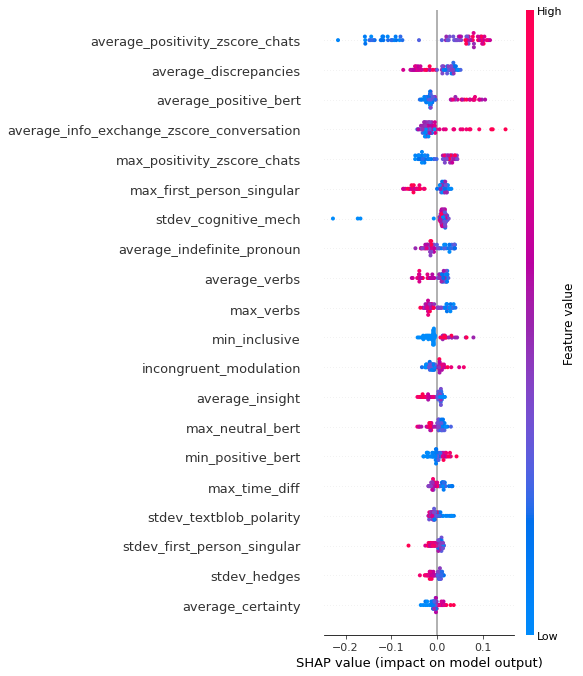

MODEL METRICS
Train Set:	R2: 0.8567	MAE: 0.3304	MSE: 0.1438	RMSE: 0.3792
Validation Set:	R2: 0.1533	MAE: 0.7375	MSE: 0.7994	RMSE: 0.8941


{'train': {'r2': 0.8567, 'mae': 0.3304, 'mse': 0.1438, 'rmse': 0.3792},
 'val': {'r2': 0.1533, 'mae': 0.7375, 'mse': 0.7994, 'rmse': 0.8941}}

In [ ]:
juries_model80 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_80/')
juries_model80.select_target(target=["majority_pct"])
juries_model80.define_model(model_type = 'rf')
juries_model80.evaluate_model(juries_model80.baseline_model, val_size = 0.2, test_size = None)

### 50% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
[[-0.77147756]
 [-0.48421745]
 [-0.06760147]
 ...
 [        nan]
 [        nan]
 [        nan]]


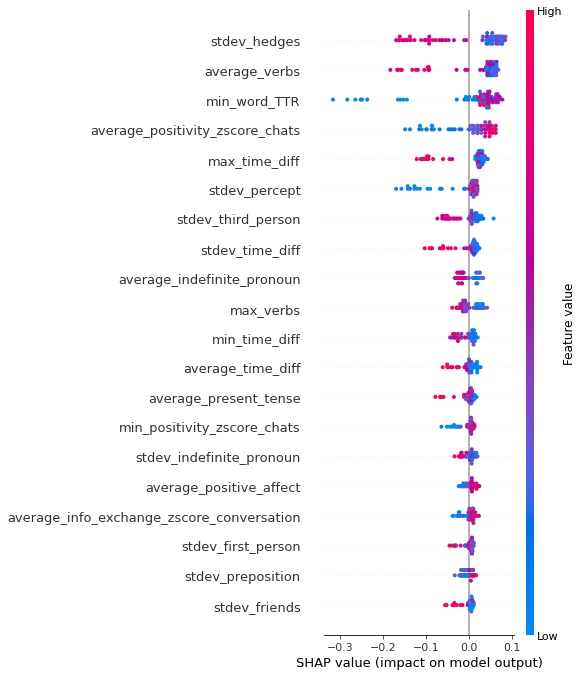

MODEL METRICS
Train Set:	R2: 0.8575	MAE: 0.3269	MSE: 0.1429	RMSE: 0.378
Validation Set:	R2: 0.0349	MAE: 0.7719	MSE: 0.9111	RMSE: 0.9545


{'train': {'r2': 0.8575, 'mae': 0.3269, 'mse': 0.1429, 'rmse': 0.378},
 'val': {'r2': 0.0349, 'mae': 0.7719, 'mse': 0.9111, 'rmse': 0.9545}}

In [8]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'rf')
juries_model50.evaluate_model(juries_model50.baseline_model, val_size = 0.2, test_size = None)

# CSOP (blended)

### Full Data (100%)

In [9]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')
csop_blended_model.evaluate_model(csop_blended_model.baseline_model, val_size = 0.2, test_size = None)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


KeyboardInterrupt: 

### 80% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.3786	MAE: 0.5292	MSE: 0.6237	RMSE: 0.7897
Validation Set:	R2: 0.1869	MAE: 0.6557	MSE: 0.8	RMSE: 0.8944


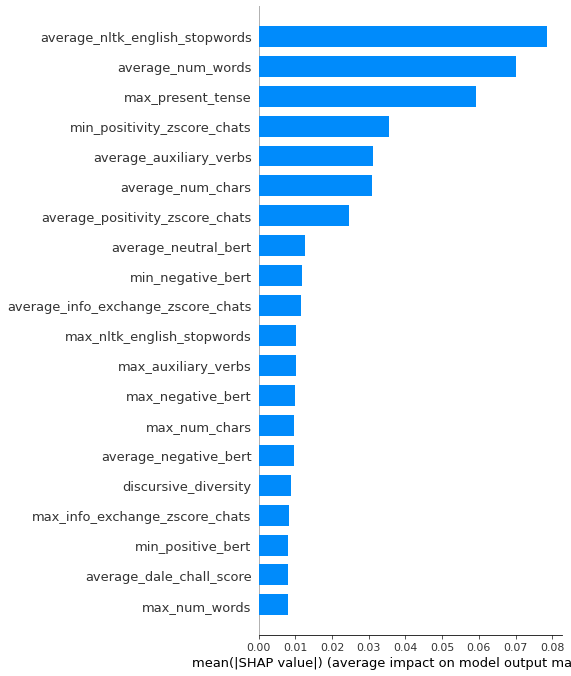

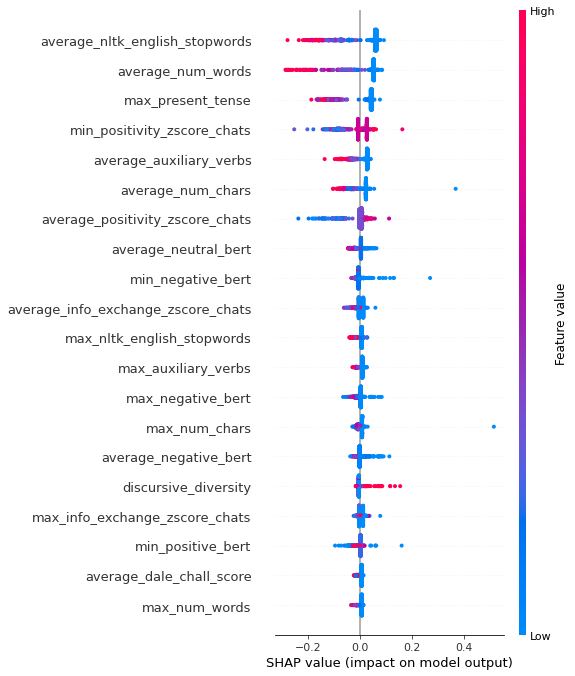

In [ ]:
csop_blended_model80 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_80/')
csop_blended_model80.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model80.define_model(model_type = 'rf')
csop_blended_model80.evaluate_model(csop_blended_model80.baseline_model, val_size = 0.2, test_size = None)

### 50% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.3767	MAE: 0.5302	MSE: 0.6256	RMSE: 0.7909
Validation Set:	R2: 0.1994	MAE: 0.659	MSE: 0.7877	RMSE: 0.8875


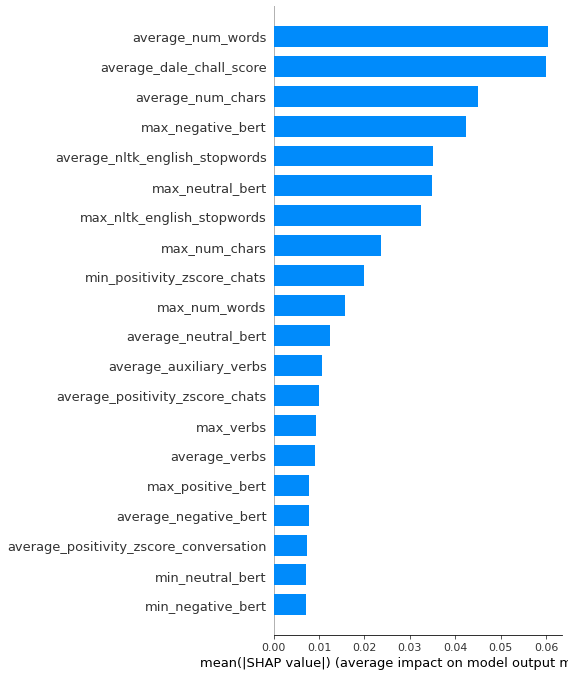

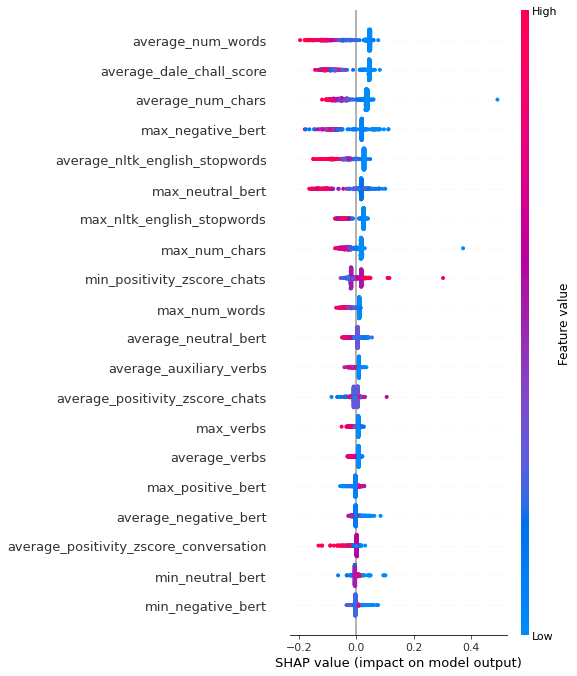

In [ ]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'rf')
csop_blended_model50.evaluate_model(csop_blended_model50.baseline_model, val_size = 0.2, test_size = None)

# CSOP (Train on CSOP I -> Test on CSOP II)

### Full Data (100%)

Checking Holdout Sets...Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.3927	MAE: 0.5232	MSE: 0.586	RMSE: 0.7655
Validation Set:	R2: 0.244	MAE: 0.7147	MSE: 0.986	RMSE: 0.993
Test Set:	R2: 0.1353	MAE: 0.7025	MSE: 0.8638	RMSE: 0.9294


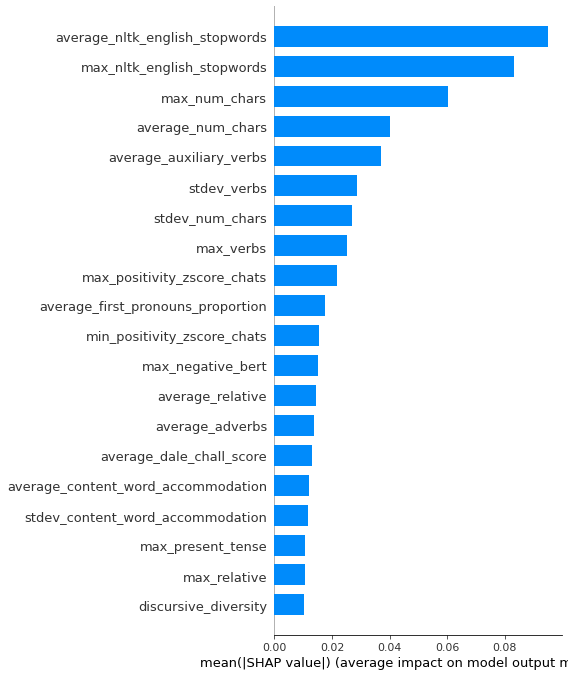

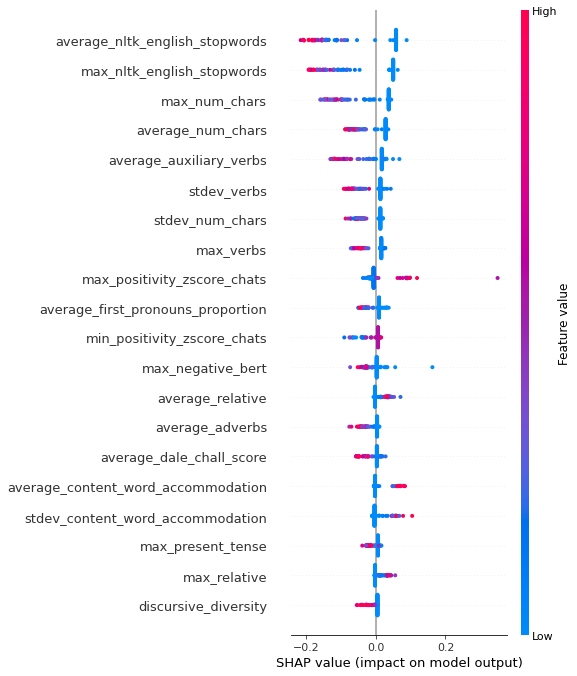

In [ ]:
csop_model = ModelBuilder(dataset_names = ["csop"], test_dataset_names=["csopII"])
csop_model.select_target(target = "zscore_efficiency")
csop_model.select_test_target(target = "efficiency")
csop_model.define_model(model_type = 'rf')
csop_model.evaluate_model(csop_model.baseline_model)

### 80% Data

Checking Holdout Sets...Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.3938	MAE: 0.5213	MSE: 0.5849	RMSE: 0.7648
Validation Set:	R2: 0.2291	MAE: 0.7363	MSE: 1.0054	RMSE: 1.0027
Test Set:	R2: 0.1354	MAE: 0.7017	MSE: 0.8637	RMSE: 0.9294


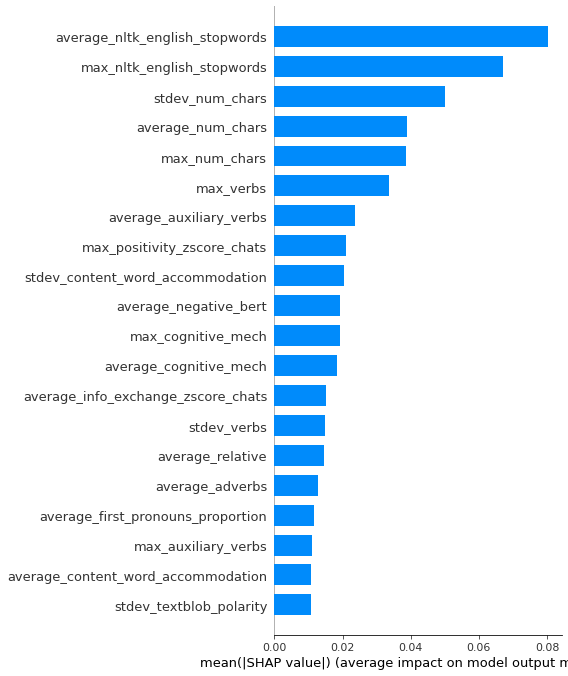

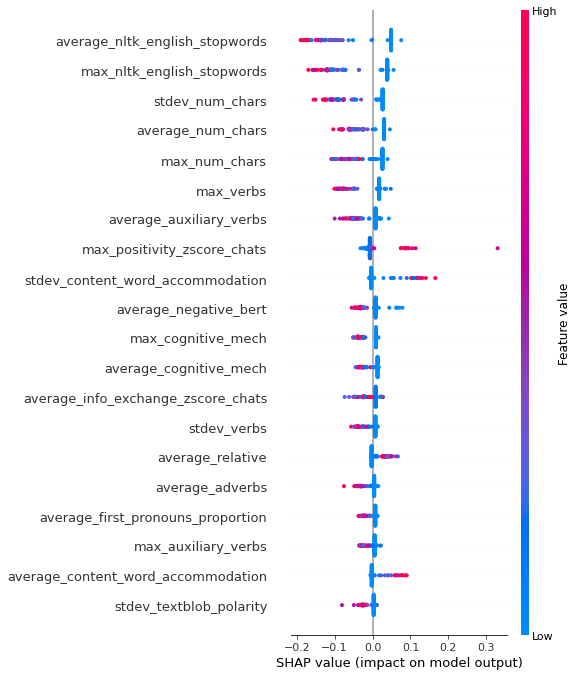

In [ ]:
csop_model80 = ModelBuilder(dataset_names = ["csop"], test_dataset_names=["csopII"], output_dir = '../output/first_80/')
csop_model80.select_target(target = "zscore_efficiency")
csop_model80.select_test_target(target = "efficiency")
csop_model80.define_model(model_type = 'rf')
csop_model80.evaluate_model(csop_model80.baseline_model)

### 50% Data

Checking Holdout Sets...Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.3879	MAE: 0.5288	MSE: 0.5906	RMSE: 0.7685
Validation Set:	R2: 0.235	MAE: 0.7271	MSE: 0.9977	RMSE: 0.9988
Test Set:	R2: 0.1201	MAE: 0.7044	MSE: 0.879	RMSE: 0.9375


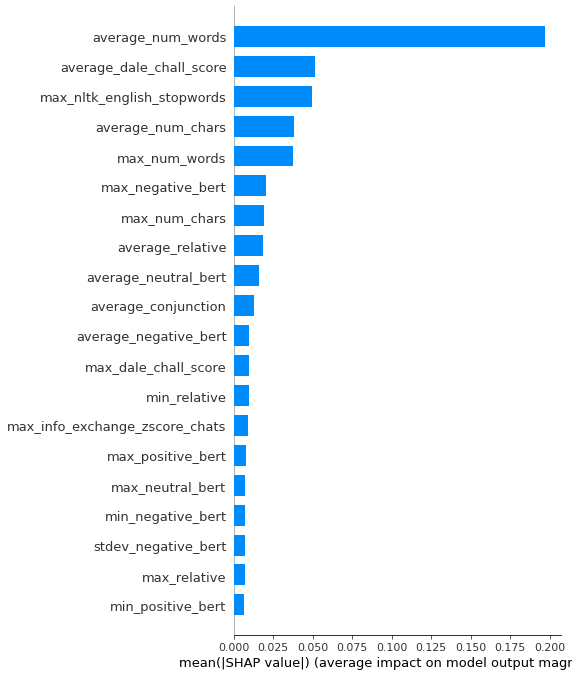

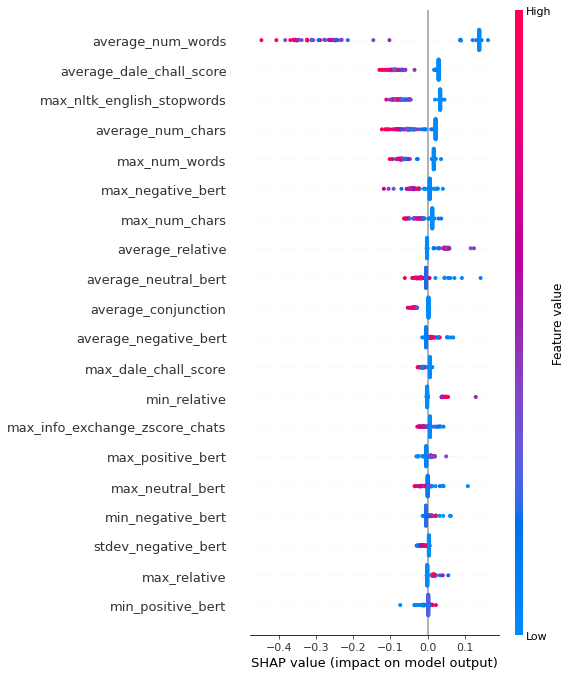

In [ ]:
csop_model50 = ModelBuilder(dataset_names = ["csop"], test_dataset_names=["csopII"], output_dir = '../output/first_50/')
csop_model50.select_target(target = "zscore_efficiency")
csop_model50.select_test_target(target = "efficiency")
csop_model50.define_model(model_type = 'rf')
csop_model50.evaluate_model(csop_model50.baseline_model)

# DAT

### Full data (100%)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4818	MAE: 0.4243	MSE: 0.5099	RMSE: 0.7141
Validation Set:	R2: 0.1199	MAE: 0.7301	MSE: 0.9092	RMSE: 0.9535


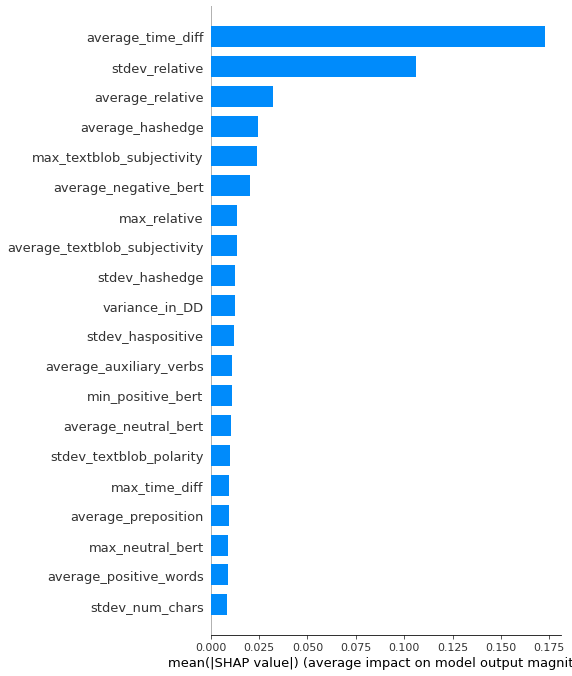

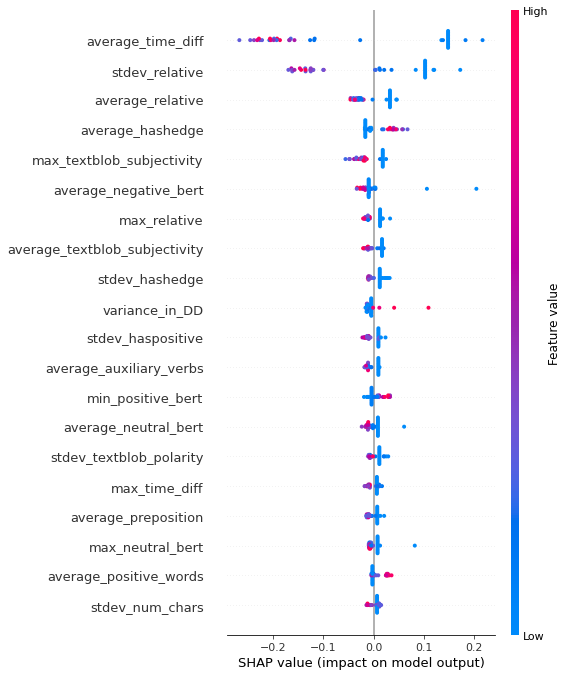

In [ ]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')
dat_model.evaluate_model(dat_model.baseline_model, val_size = 0.2, test_size = None)

### 80% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4848	MAE: 0.4267	MSE: 0.507	RMSE: 0.712
Validation Set:	R2: 0.1142	MAE: 0.7303	MSE: 0.9151	RMSE: 0.9566


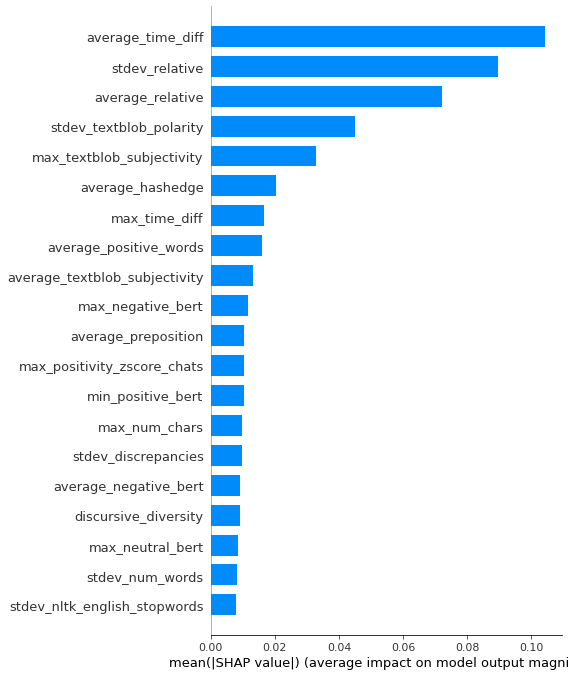

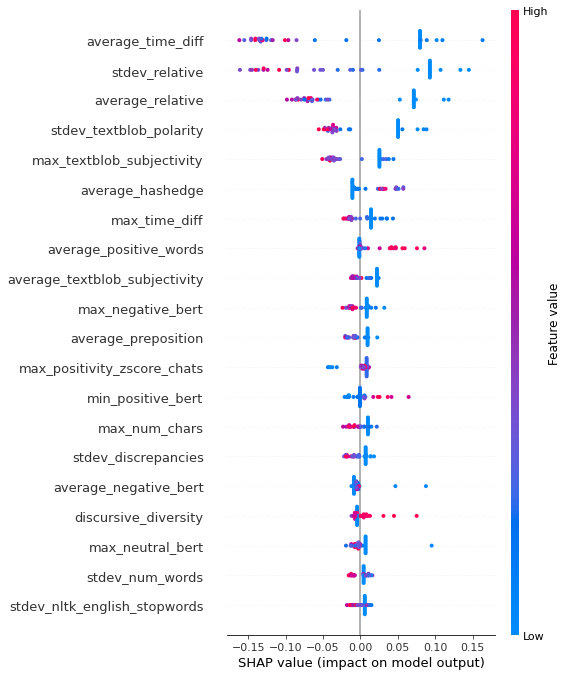

In [ ]:
dat_model80 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_80/')
dat_model80.select_target(target=["efficiency"])
dat_model80.define_model(model_type = 'rf')
dat_model80.evaluate_model(dat_model80.baseline_model, val_size = 0.2, test_size = None)

### 50% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.4713	MAE: 0.4454	MSE: 0.5203	RMSE: 0.7213
Validation Set:	R2: 0.1567	MAE: 0.7264	MSE: 0.8712	RMSE: 0.9334


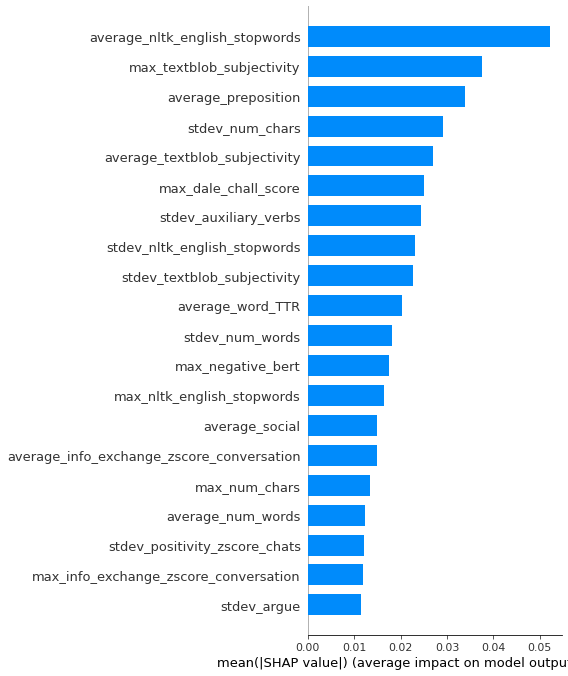

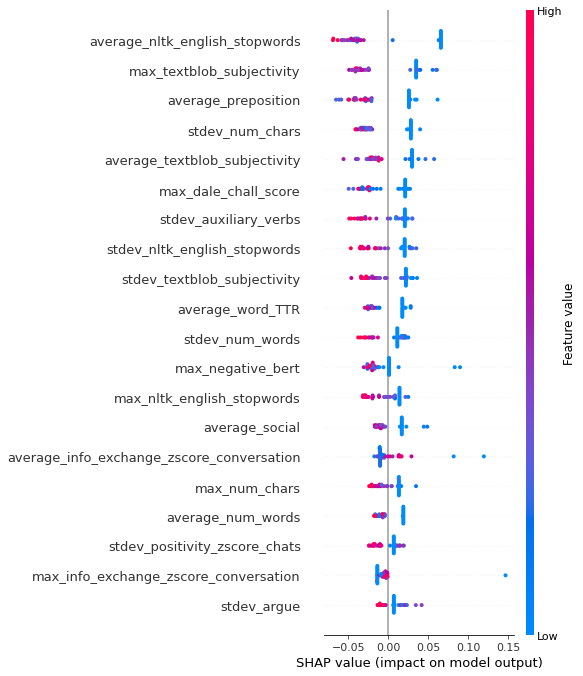

In [ ]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')
dat_model50.evaluate_model(dat_model50.baseline_model, val_size = 0.2, test_size = None)

# Estimation

### Full Data (100%)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.7706	MAE: 0.1936	MSE: 0.2688	RMSE: 0.5185
Validation Set:	R2: -0.5158	MAE: 0.3467	MSE: 0.5163	RMSE: 0.7185


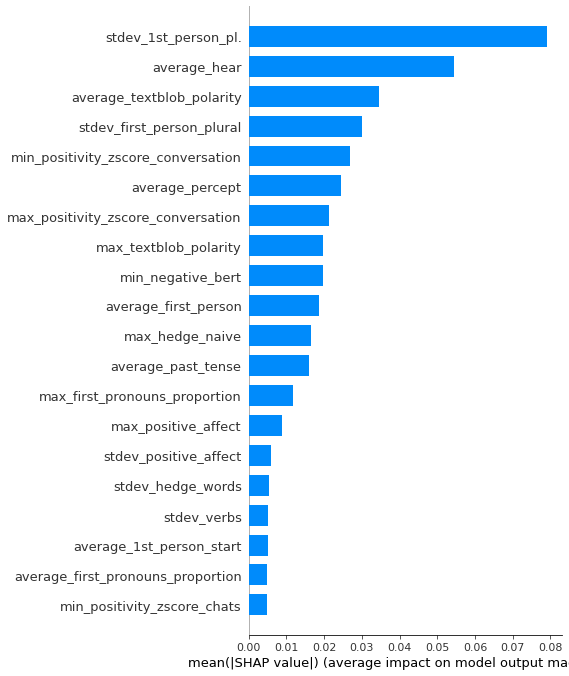

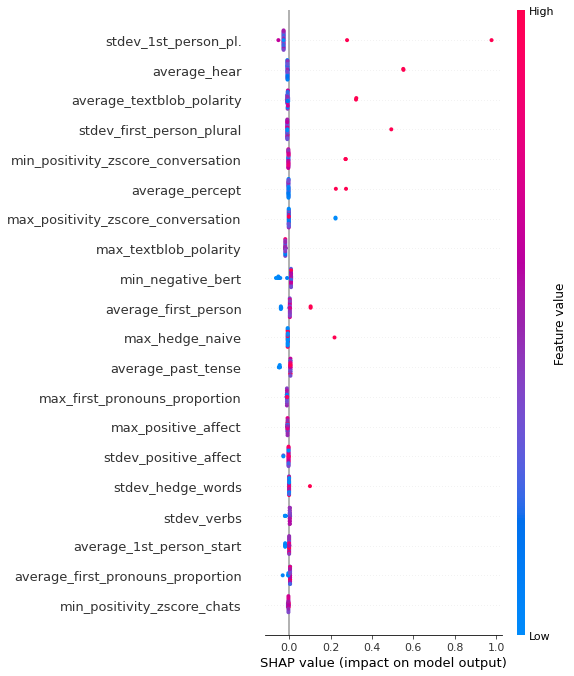

In [ ]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')
estimation_blended_model.evaluate_model(estimation_blended_model.baseline_model, val_size = 0.2, test_size = None)

### 80% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.8164	MAE: 0.1249	MSE: 0.2151	RMSE: 0.4638
Validation Set:	R2: -0.2602	MAE: 0.2988	MSE: 0.4292	RMSE: 0.6551


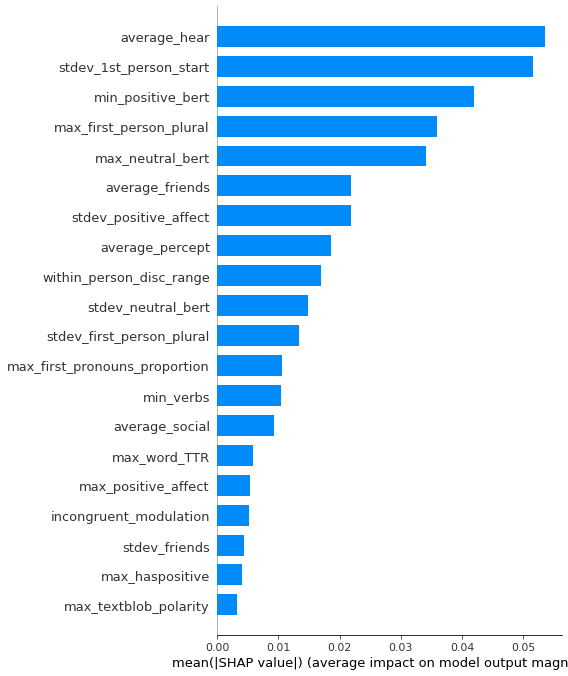

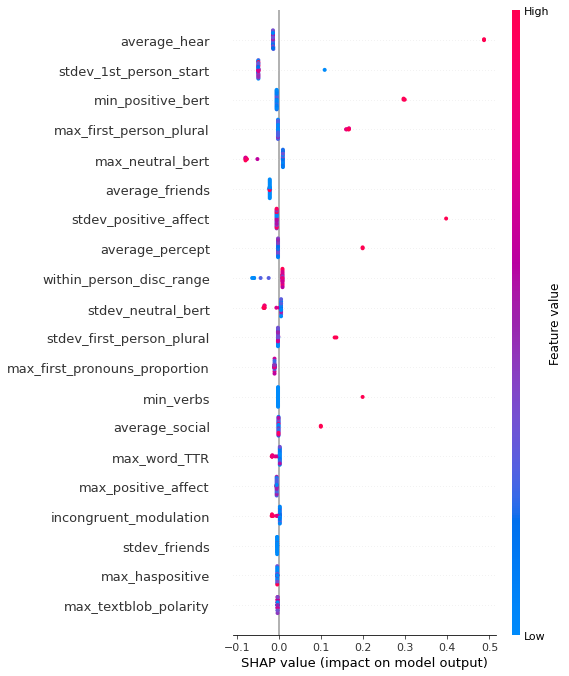

In [ ]:
estimation_blended_model80 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_80/')
estimation_blended_model80.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model80.define_model(model_type = 'rf')
estimation_blended_model80.evaluate_model(estimation_blended_model80.baseline_model, val_size = 0.2, test_size = None)

### 50% Data

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
MODEL METRICS
Train Set:	R2: 0.8254	MAE: 0.1108	MSE: 0.2046	RMSE: 0.4523
Validation Set:	R2: -0.4076	MAE: 0.266	MSE: 0.4794	RMSE: 0.6924


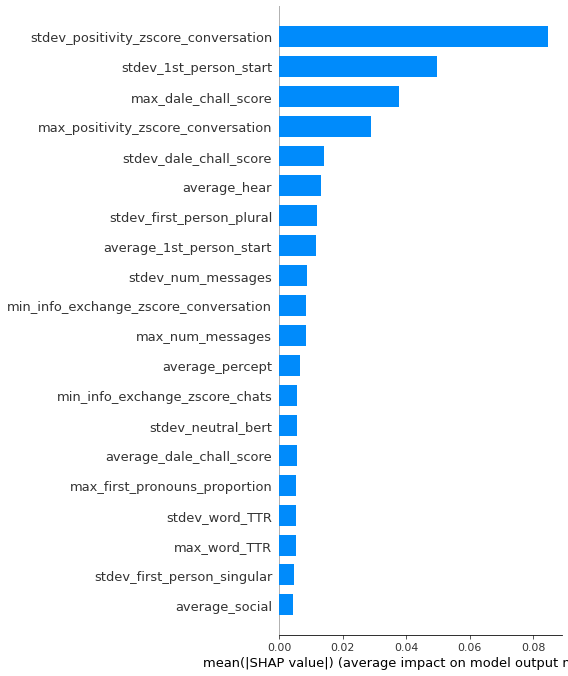

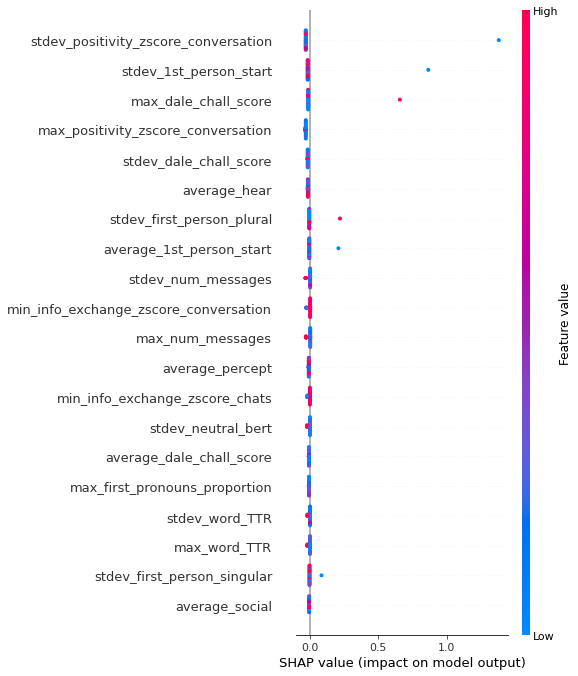

In [ ]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'rf')
estimation_blended_model50.evaluate_model(estimation_blended_model50.baseline_model, val_size = 0.2, test_size = None)